In [1]:
from deal_data_pre.deal_model import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 数据读取

* 一般方法
  
  使用pandas的read_系列的方法读取文件
  
* 当文件数很大时

  使用pandas的分块读取，在读取的read_系列函数里面设置**参数iterator=True**，这时候就变成了一个生成器，接下来就使用  **这个生成器.get_chunk(chunkSize)**  获取每一个分块的数据，可以将它读取到一个容器中
  
  最后将这个容器中的数据使用  **pandas.concat()**  合并。
  
* 对于很大的数据还可以转换一下数据，将np.float64变为np.float32,这样子可以整体降低数据的大小，但是会损失一定的精度

In [2]:
data_original = pd.read_csv("数据2.csv")


# 记录一波分块读取的操作，有时候notebook出现内存泄漏的错误，于是新学点方法解决一下这个问题
# data_original = pd.read_csv("数据2.csv",engine = 'python',iterator=True)  
# loop = True
# chunkSize = 1000
# chunks = []
# while loop:
#     try:
#         chunk = data_original.get_chunk(chunkSize)
#         chunks.append(chunk)

#     except StopIteration:
#         loop = False
#         print("Iteration is stopped.")
# print('开始合并')
# data_original = pd.concat(chunks, ignore_index= True)

C:\Users\86158\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 数据的概况

* 可以使用describe或者info了解一下数据的具体情况
  
  **注意点：describe只是反映数值类型特征的基本情况**


In [3]:
# data_original.describe()
data_original.info() 
# 从打印出的情况来看这里有23个数值类特征，样本个数为1400831，并且有部分信息存在缺失值
# 有五个非数值类型的特征
# 结合给出的数据说明，可以了解到这个五个非数值类型的特征为order_pay_time（付款时间）、
# customer_province（用户所在省份）、customer_city（用户所在城市）、以及商品最新上架时间和最新下架时间

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400831 entries, 0 to 1400830
Data columns (total 28 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   order_detail_id         1400831 non-null  int64  
 1   order_id                1400831 non-null  int64  
 2   order_total_num         1400831 non-null  int64  
 3   order_amount            1400831 non-null  float64
 4   order_total_payment     1400831 non-null  float64
 5   order_total_discount    1400831 non-null  float64
 6   order_pay_time          1400831 non-null  object 
 7   order_status            1400831 non-null  int64  
 8   order_count             1400831 non-null  int64  
 9   is_customer_rate        1315964 non-null  float64
 10  order_detail_status     1400831 non-null  int64  
 11  order_detail_goods_num  1400831 non-null  int64  
 12  order_detail_amount     1315964 non-null  float64
 13  order_detail_payment    1400831 non-null  float64
 14  or

# 缺失值的处理

这个会比较麻烦，主要是要根据数据的情况作出一些不同的措施

一般情况下：

* 对待数值型的数据，使用平均数或者中位数填补

* 对待object类型的数据使用众数填补

* 还有更多的是依据具体的情况使用别的方法填补

[这里是之前缺失值处理的笔记](https://github.com/axiaokun/Preprocessing-learning/blob/master/2-House%20Prices-Advanced%20Regression%20Techniques/%E7%BC%BA%E5%A4%B1%E5%80%BC.ipynb)

In [4]:
missvalues = data_original.isnull().sum()
missvalues[missvalues > 0].sort_values(ascending=False)
# 查找缺失值，并按照缺失值数量从大到小排序打印出含有缺失值的变量（特征）

# 分析：
# 前三个特征缺失太严重了，考虑舍弃这三个特征
# 用户所在省份和城市缺失部分可以填补“None”作为“未知”类
# order_detail_amount（子订单应付总金额）这一部分的缺失值可以从实付金额和优惠金额计算出来进行填补
# is_customer_rate（用户是否评价）添加‘-1’表示缺失这部分数据
# 用户ID缺失这一个只有67份，相对于这份一百四多万的数据来说是微乎其微的，所以可以考虑忽略这部分样本
# 注意：舍弃特征和舍弃样本是不一样的

is_member_actived      849229
member_status          849229
customer_gender        849229
customer_city           85516
customer_province       85516
order_detail_amount     84867
is_customer_rate        84867
customer_id                67
dtype: int64

In [5]:
# 下面就开始填补缺失值
data_fill = fill_missing_values(data_original, ['customer_city', 'customer_province'])  # 填补用户所在省份和城市缺失值为“None”
data_fill = fill_missing_values(data_fill, ['is_customer_rate'], fill_values=-1)  # 填补is_customer_rate的缺失值为-1表示缺失这部分数据
data_fill.drop(['is_member_actived', 'member_status', 'customer_gender'], axis=1, inplace=True) # 删除缺失值太多的特征
data_fill.dropna(axis=0, how='any', subset=['customer_id'], inplace=True)  # 删除customer_id这个特征中带有缺失值的样本

nan_index = np.where(np.isnan(data_fill['order_detail_amount']))[0]  # 这部分是对子订单总金额缺失值的处理
data_fill['order_detail_payment'][nan_index], data_fill['order_detail_discount'][nan_index]
fill_values = data_fill['order_detail_payment'][nan_index]+data_fill['order_detail_discount'][nan_index]
for index, value in zip(nan_index, fill_values):
    data_fill.loc[index, 'order_detail_amount'] = value

In [6]:
missvalues = data_fill.isnull().sum()
missvalues[missvalues > 0].sort_values(ascending=False) 
# 重新检查缺失值，可观察到确实缺失值已经被消灭了

Series([], dtype: int64)

# 条形图

这边可以看到有用户所在省份，于是我们可以绘制所在省份这个离散标签对应的金额总额，大概的步骤有：

* 首先要将父子订单的总金额合并为一个新的特征，这个才是实际的总消费额。

* 然后我们要对数据进行分组运算，以**所在省份** 为分组的依据，计算 **总金额** 的平均值和数量

* 接下来就是利用这些数据来绘制条形图（注意：**中文显示问题**）

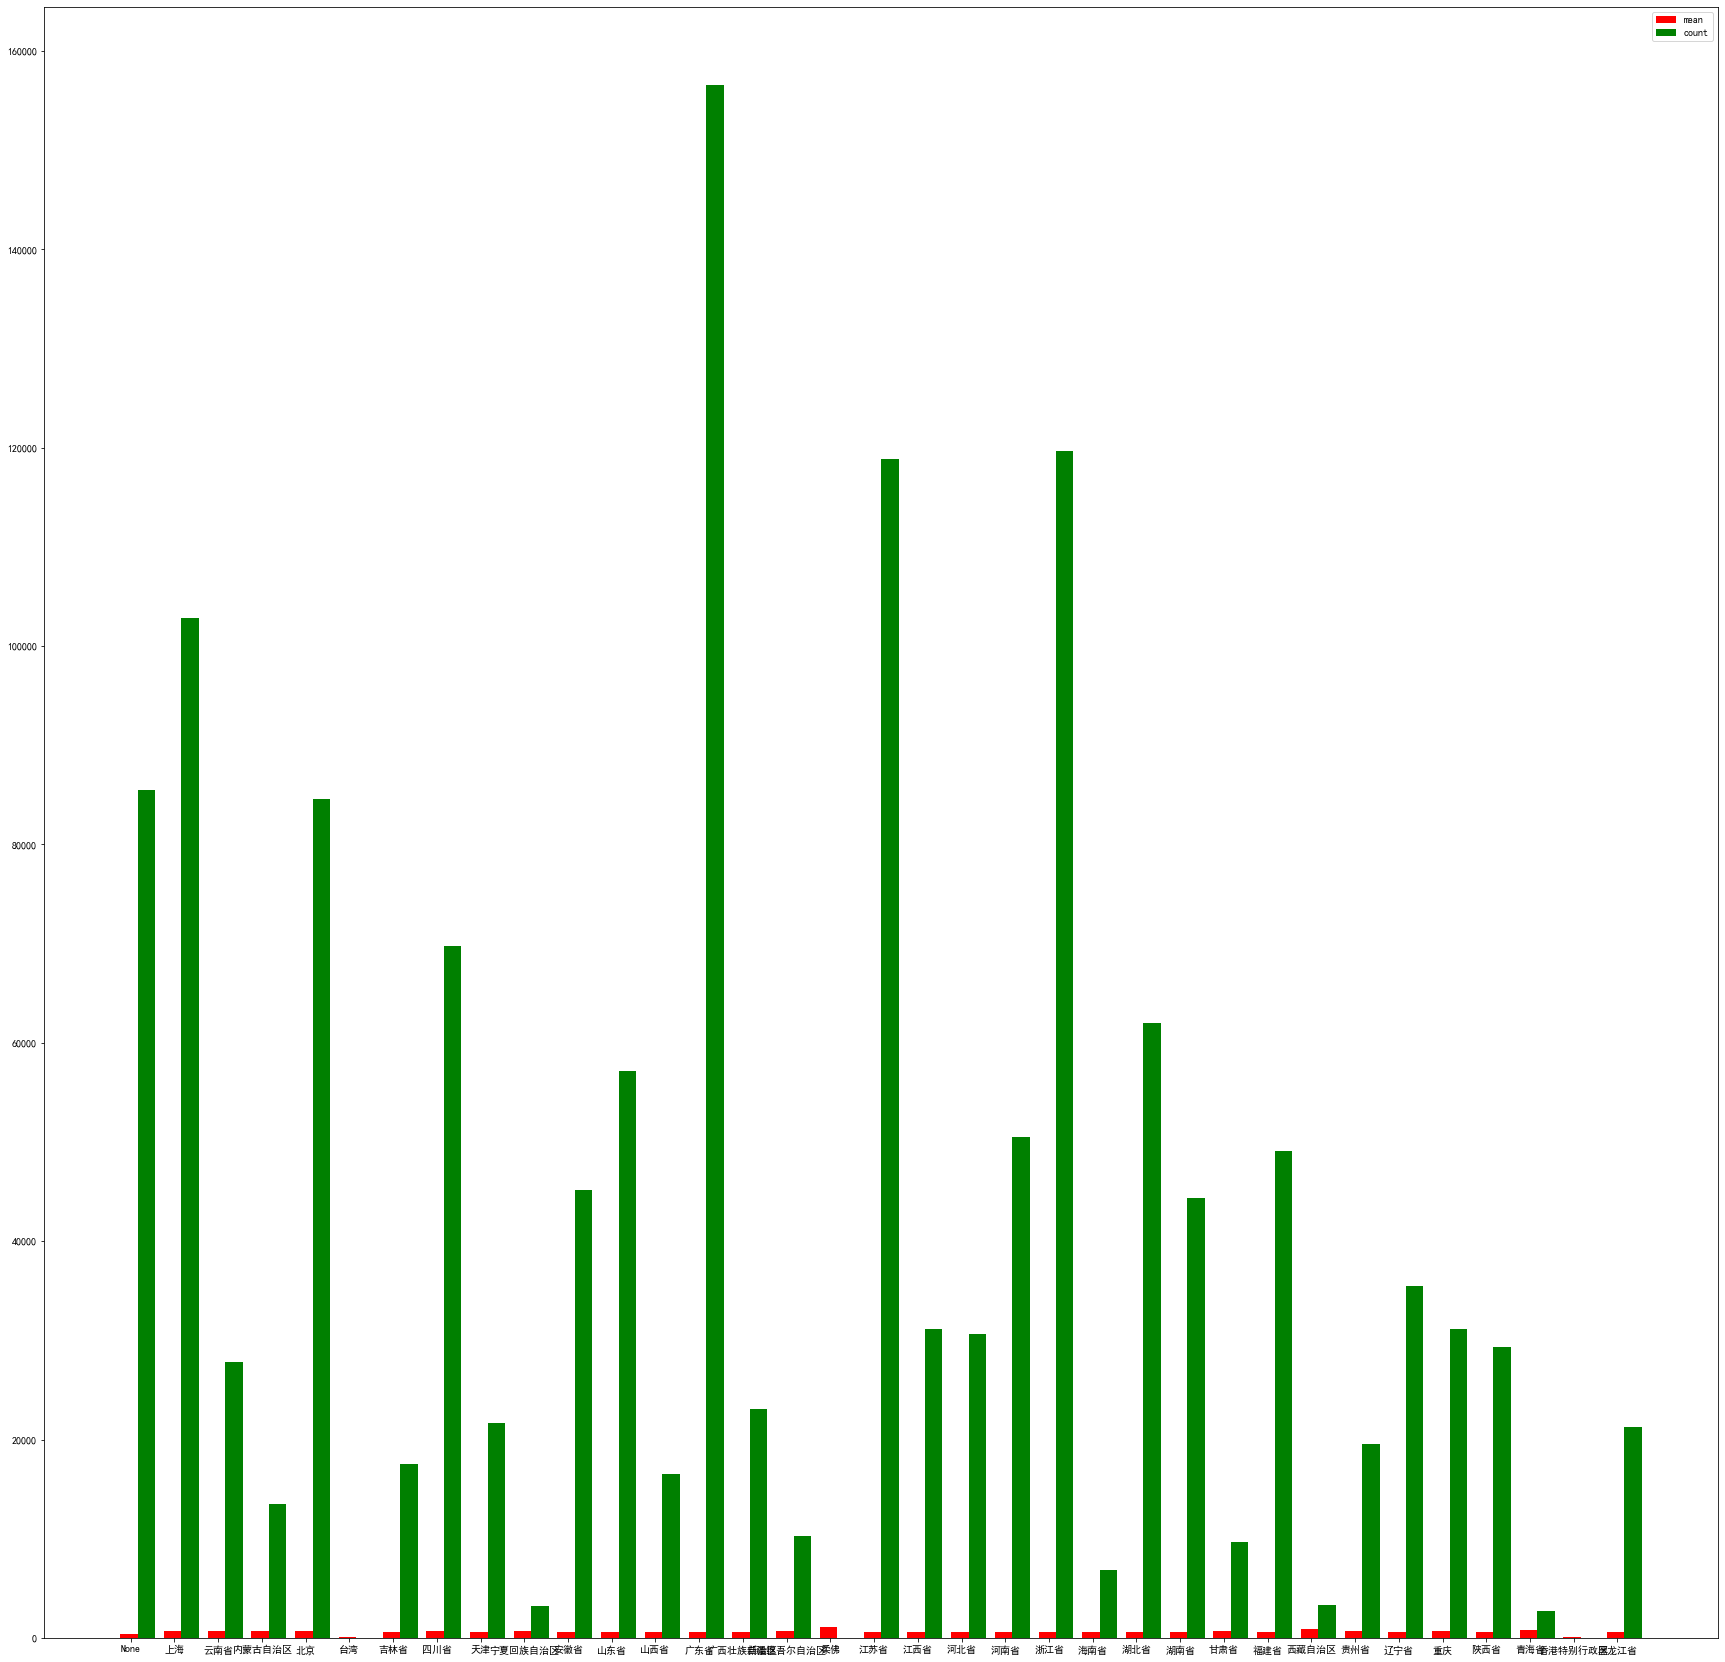

In [8]:
# 通过绘制不同省份对应的消费总额和消费次数，得出主要面对的销售地区，可以针对不同地区的消费情况作出不同的策略

data_fill['sum_total'] = data_fill['order_amount'] + data_fill['order_detail_amount']  # 全部订单金额作为新的一列
groupby_data = data_fill.groupby(['customer_province'])[['sum_total']].agg(['mean', 'count'])  # 分组运算
index_name = groupby_data.index  # 用户所在省份
index_num = len(groupby_data.index.values)  

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.figure(figsize=(30, 30))  # 设置画布大小
rect1 = plt.bar([i*5 for i in range(index_num)], height=groupby_data[('sum_total',   'mean')].values, width=2, color='r', label='mean')  # 平均消费总额
rect2 = plt.bar([i*5+2 for i in range(index_num)], height=groupby_data[('sum_total',   'count')].values, width=2, color='g', label='count') # 消费数量
plt.xticks([i*5+0.2 for i in range(index_num)], index_name)  # X轴上的坐标，不同的省份名称
plt.legend()

# 时间序列及折线图
首先可以观察到数据中包含有付款时间，于是我们可以依据时间的序列绘制出在2013年中销售金额的变化，在上面绘制条形图的过程中我们已经将父子订单的金额相加合并为新的一列，因此我们现在只需要处理一下时间序列

* 处理时间序列

  1.使用库--pandas
  
  2.操作流程
  
  对于操作流程，首先我们应该使用pandas.to_datatime处理一下时间字符串，将处理后的这个Series对象作为这个DataFrame中的一列；
  
  然后将这一列作为引索index，这里可以使用DataFrame.set_index("刚刚处理后的Series对象")；
  
  接下来就可以使用时间序列作为引索，例如data_fill['2013-01']就可以获得时间发生在2013-01月份的所有事件
  
大概的操作就记录在上面，之后我们就可以获取3013年中每一个月份中的销售总金额，绘制折线图，观察变化。

In [10]:
data_fill['time_index'] = pd.to_datetime(data_fill['order_pay_time'])  # 处理时间序列
data_fill = data_fill.set_index('time_index')  # 将它作为引索

In [31]:
month_monney = []  # 存储每个月份的总金额
str_time = ['2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12']
for i in str_time:
    month_monney.append(data_fill[i]['sum_total'].sum())

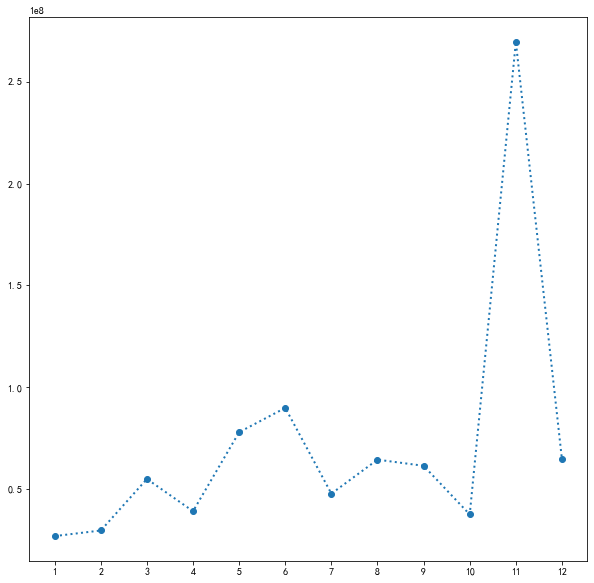

In [37]:
# 简单绘制折线图

plt.figure(figsize=(10, 10))
x = [i+1 for i in range(12)]
plt.xticks(x, x)
plt.plot(x, month_monney, linestyle=':', marker='o', linewidth=2)

从图中可以看出几点：

* 首先是有两个峰值，一个是六月份，一个是十一月份（盲猜6.18和双十一）

* 然后可以看出在第一季度销售总金额处于较低位